In [1]:
import tensorflow as tf
from src.dataset import dataset_tf, validation_tf
from src.audio import to_mfccs_dataset
from src.model import get_seq_model, get_conv_model, get_conv_model_mini, callbacks
from src.plots import plot_history, plot_mfccs

In [2]:
train_ds, val_ds, label_names = dataset_tf("./dataset/sbcm", 0.90)

Found 688 files belonging to 2 classes.
Using 69 files for training.
Using 619 files for validation.
label names: ['noqueen' 'queen']
(TensorSpec(shape=(None, 4000, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
Example audio shape: (32, 4000)
Example label shape: (32,)
513 44100


2024-03-22 22:47:53.779312: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2024-03-22 22:47:53.779344: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-03-22 22:47:53.779351: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-03-22 22:47:53.779390: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-22 22:47:53.779413: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Label: queen
Waveform shape: (4000,)
MFCCs shape: (12, 16)
Spectrogram shape: (118, 129, 1)
513 44100
Label: noqueen
Waveform shape: (4000,)
MFCCs shape: (12, 16)
Spectrogram shape: (118, 129, 1)


In [3]:
train_mfccs_ds = to_mfccs_dataset(train_ds)
val_mfccs_ds = to_mfccs_dataset(val_ds)

513 44100
513 44100


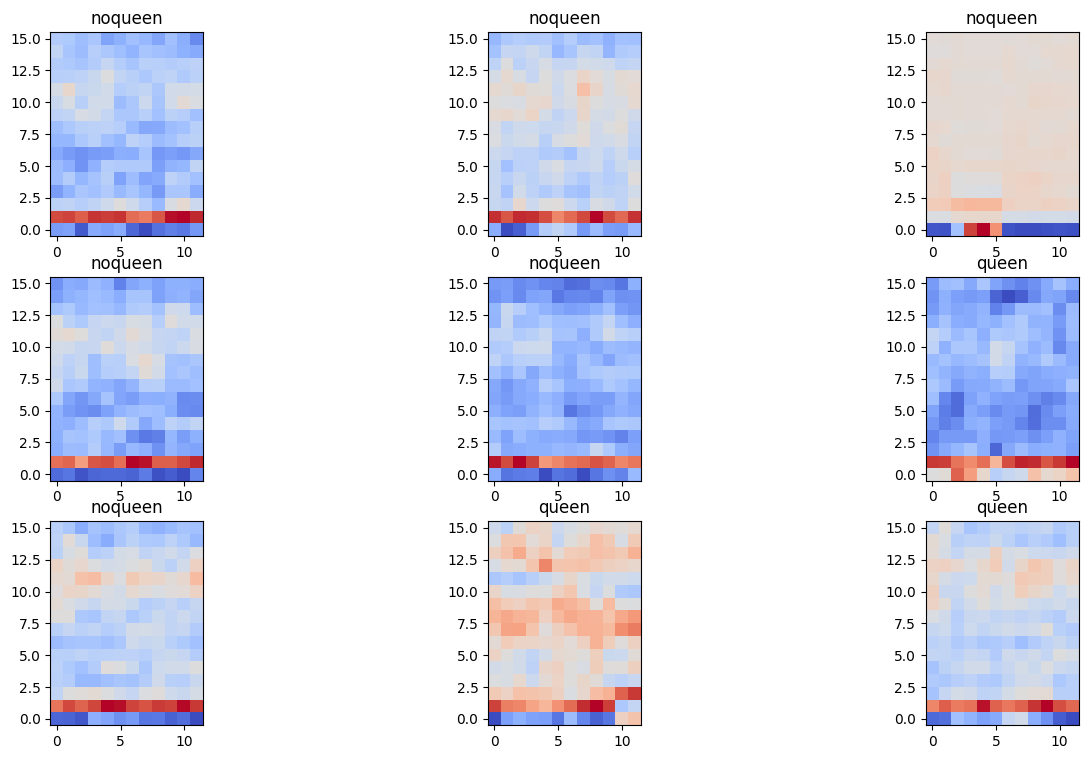

In [4]:
for example_spectrograms, example_spect_labels in train_mfccs_ds.take(1):
  break

input_shape = example_spectrograms.shape[1:]
plot_mfccs(example_spectrograms, example_spect_labels, label_names)

In [5]:
train_mfccs_ds = train_mfccs_ds.map(lambda x, y: (tf.expand_dims(x, -1), y))
val_mfccs_ds = val_mfccs_ds.map(lambda x, y: (tf.expand_dims(x, -1), y))
for example_spectrograms, example_spect_labels in train_mfccs_ds.take(1):
  break
input_shape = example_spectrograms.shape[1:]
input_shape

TensorShape([12, 16, 1])

In [6]:
train_mfccs_ds = train_mfccs_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_mfccs_ds = val_mfccs_ds.cache().prefetch(tf.data.AUTOTUNE)

# Conv

In [7]:
model_conv = get_conv_model_mini(input_shape, len(label_names))
model_conv.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

In [8]:
history = model_conv.fit(
    train_mfccs_ds, 
    validation_data=val_mfccs_ds, 
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20


2024-03-22 22:48:01.801312: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 1s 214ms/step - loss: 0.7415 - accuracy: 0.4493 - val_loss: 0.7128 - val_accuracy: 0.4976
Epoch 2/20
3/3 [==============================] - 0s 33ms/step - loss: 0.6794 - accuracy: 0.5072 - val_loss: 0.7163 - val_accuracy: 0.4895
Epoch 3/20
3/3 [==============================] - 0s 34ms/step - loss: 0.6799 - accuracy: 0.5797 - val_loss: 0.7309 - val_accuracy: 0.5008
Epoch 4/20
3/3 [==============================] - 0s 33ms/step - loss: 0.6810 - accuracy: 0.5652 - val_loss: 0.7294 - val_accuracy: 0.4992
Epoch 5/20
3/3 [==============================] - 0s 32ms/step - loss: 0.6612 - accuracy: 0.5652 - val_loss: 0.6884 - val_accuracy: 0.5024
Epoch 6/20
3/3 [==============================] - 0s 33ms/step - loss: 0.6195 - accuracy: 0.5797 - val_loss: 0.6596 - val_accuracy: 0.5315
Epoch 7/20
3/3 [==============================] - 0s 35ms/step - loss: 0.6073 - accuracy: 0.6522 - val_loss: 0.6335 - val_accuracy: 0.6414
Epoch 8/20
3/3 [=====================

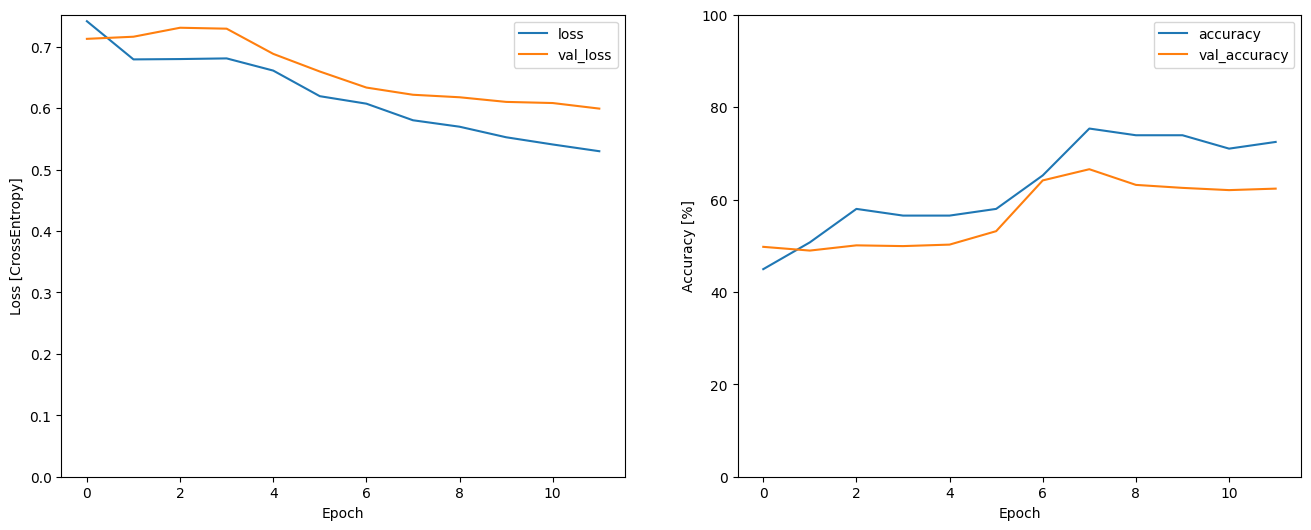

In [9]:
plot_history(history)

# Reinforce

In [10]:
model = tf.keras.models.load_model("osbh.h5")

### Check non-reinforced model perf

In [11]:
results = model.evaluate(val_mfccs_ds)

20/20 [==============================] - 0s 5ms/step - loss: 1.6077 - accuracy: 0.4879


In [12]:
history = model.fit(
    train_mfccs_ds, 
    validation_data=val_mfccs_ds, 
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
3/3 [==============================] - 0s 59ms/step - loss: 1.2618 - accuracy: 0.4783 - val_loss: 0.8907 - val_accuracy: 0.5735
Epoch 2/50
3/3 [==============================] - 0s 33ms/step - loss: 0.9513 - accuracy: 0.5652 - val_loss: 0.7998 - val_accuracy: 0.6058
Epoch 3/50
3/3 [==============================] - 0s 32ms/step - loss: 0.7305 - accuracy: 0.6377 - val_loss: 0.9122 - val_accuracy: 0.5024
Epoch 4/50
3/3 [==============================] - 0s 32ms/step - loss: 0.7163 - accuracy: 0.6087 - val_loss: 0.7475 - val_accuracy: 0.5638
Epoch 5/50
3/3 [==============================] - 0s 33ms/step - loss: 0.5349 - accuracy: 0.6812 - val_loss: 0.6573 - val_accuracy: 0.6704
Epoch 6/50
3/3 [==============================] - 0s 32ms/step - loss: 0.5349 - accuracy: 0.7101 - val_loss: 0.6440 - val_accuracy: 0.6882
Epoch 7/50
3/3 [==============================] - 0s 33ms/step - loss: 0.4897 - accuracy: 0.7246 - val_loss: 0.6532 - val_accuracy: 0.6511
Epoch 8/50
3/3 [===========

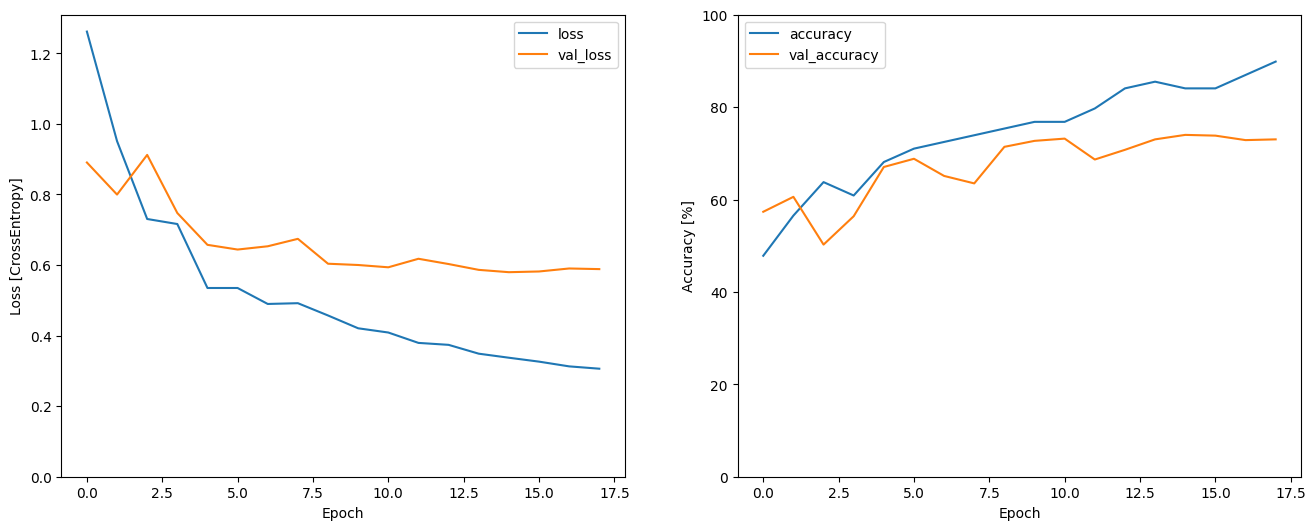

In [14]:
plot_history(history)

In [14]:
model_conv.save("osbh_reinf.h5")

/Users/lantain/miniconda3/envs/tf/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
